In [650]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("UsArrests.csv", delimiter=',', skipinitialspace=True)
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.200,236,58,21.200
1,Alaska,10.000,263,48,44.500
2,Arizona,8.100,294,80,31.000
3,Arkansas,8.800,190,50,19.500
4,California,9.000,276,91,40.600


### Summarise the statistical properties of the columns

In [651]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

#The describe function give us insight into the statistical properties of the columns
stats = df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


### Determine if we have any missing values

In [652]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


### Examine types of variables

In [653]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


### Plot histograms

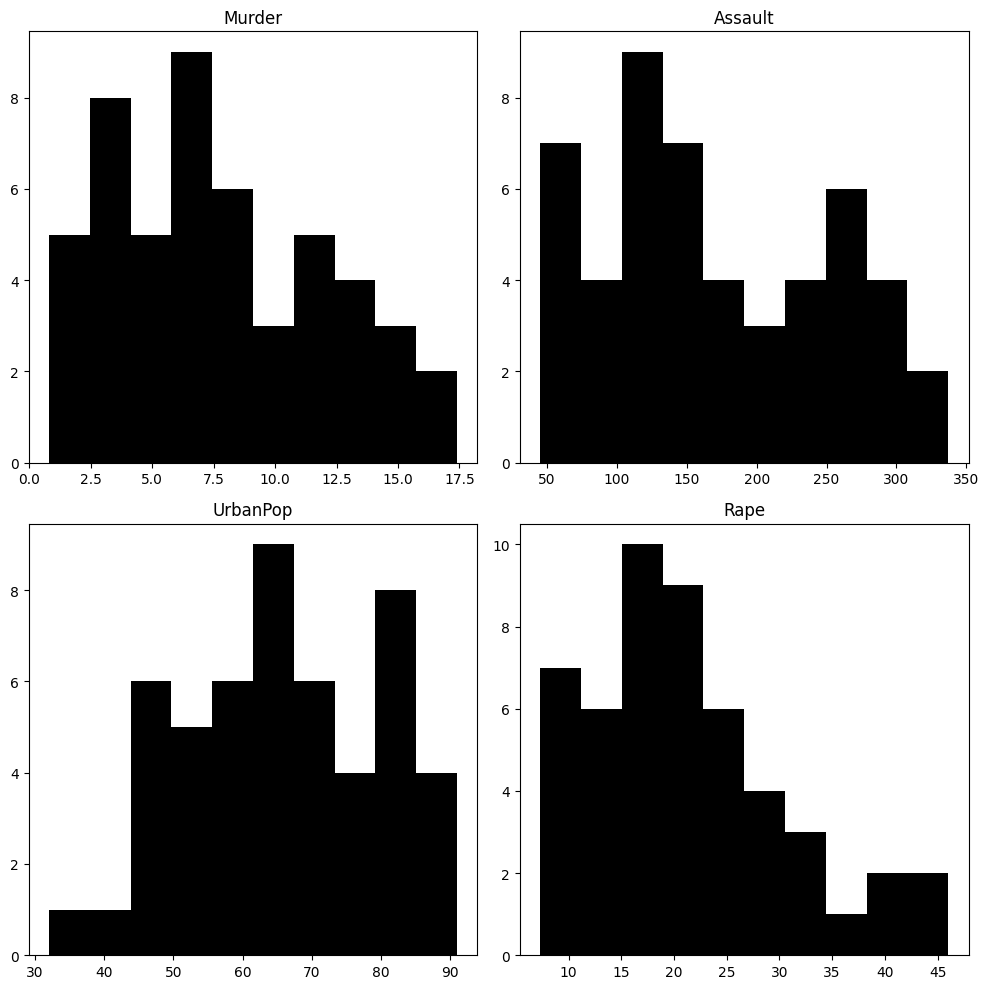

In [654]:
histograms = df.hist(color='black', grid=False, figsize=(10, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()

### compile the tabular information we have so far into a single dataframe

In [655]:
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary

,missing,mean,std,min,max
City,0,NaN,NaN,NaN,NaN
Murder,0,7.79,4.36,0.80,17.40
Assault,0,170.76,83.34,45.00,337.00
UrbanPop,0,65.54,14.47,32.00,91.00
Rape,0,21.23,9.37,7.30,46.00


## Correlation Analysis

In [656]:
cities = df['City']
corr_df = df.drop(["City"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

<Axes: >

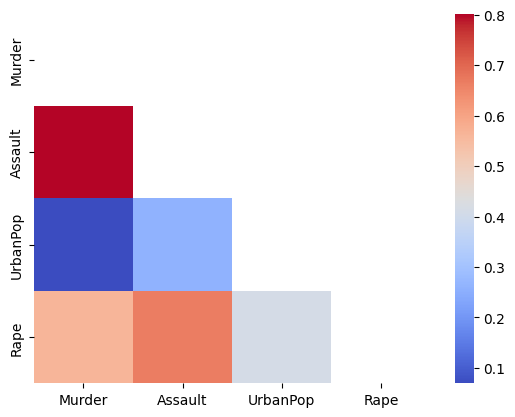

In [657]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(np.bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

It is evident in this heatmap that there is a strong correlation between assault and murder. Urban pop has a weak correlation with murder and assault while it looks like rape appears has a positive correlation with Murder and Assault and a weaker correlation with UrbanPop.

### PCA

In [658]:
from sklearn.decomposition import PCA 

np.set_printoptions(precision=2)

X = df.drop(["City"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.80,-11.45,-2.49,2.41
1,92.83,-17.98,20.13,-4.09
2,124.07,8.83,-1.69,-4.35
3,18.34,-16.70,0.21,-0.52
4,107.42,22.52,6.75,-2.81


In [659]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [660]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [661]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


### Biplot 1

In [662]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = cities[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

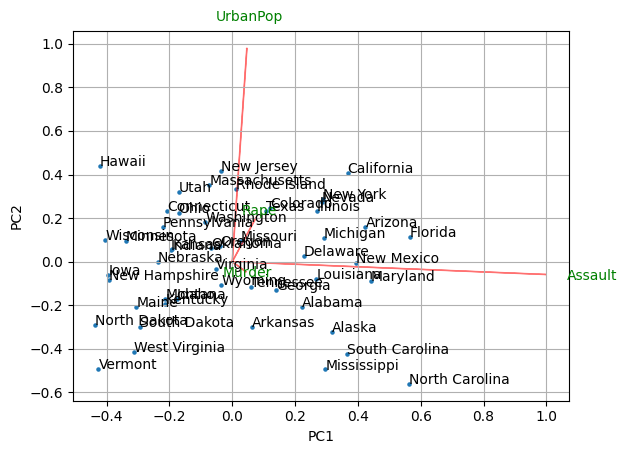

In [663]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(cities))
plt.show()

From this biplot we can see that UrbanPop and Assault are the most important features as the arrow to both of these dominate the plot

# Feature importance

In [664]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


We can clearly see that Assault has the highest importance in the first principle component while UrbanPop has the highest importance in the second principle component with Rape also having slightly more importance than the other features.

### Standardise data

In [665]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,-1.133,-0.444,-0.156
1,1.950,-1.073,2.040,0.439
2,1.763,0.746,0.055,0.835
3,-0.141,-1.120,0.115,0.183
4,2.524,1.543,0.599,0.342


### Biplot 2

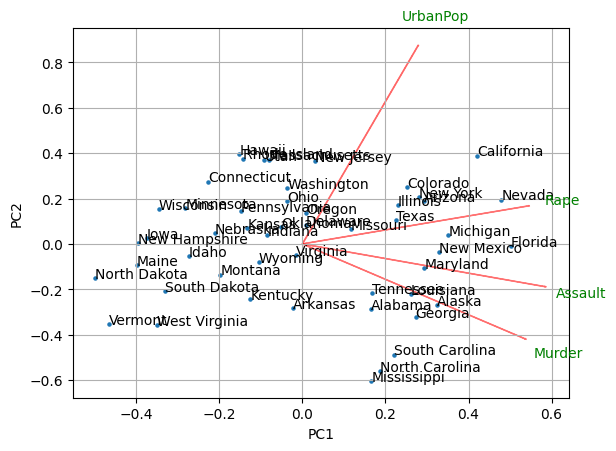

In [666]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it.

### Feature importance

In [667]:
pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


Inspecting the feature importance now, we see that most of the variables contribute fairly evenly, with only some with low importance and UrbanPop having the highest importance by far in the second principle component.

### Cumulative variance plot

Text(0.5, 1.0, 'Cumulative Explained Variance')

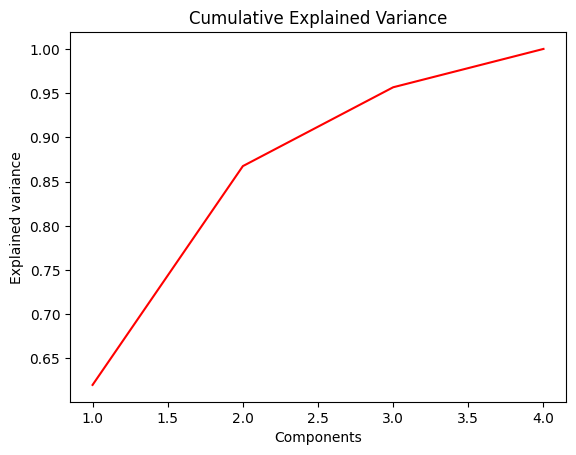

In [668]:
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

### Scree plot

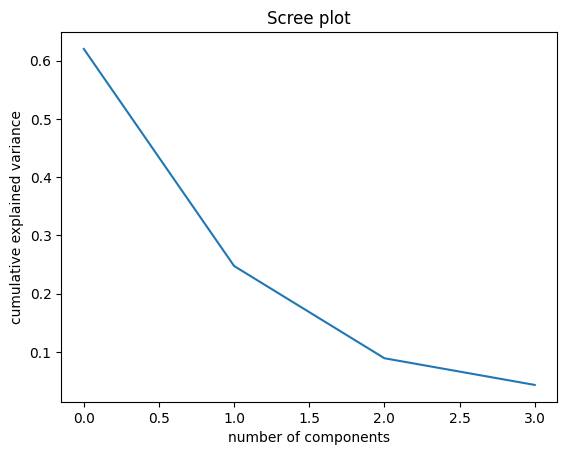

In [669]:
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

In [670]:
pca_df = pd.DataFrame(X_std_trans[:,0:4], index = df.index)
pca_df.head()

,0,1,2,3
0,0.986,-1.133,-0.444,-0.156
1,1.950,-1.073,2.040,0.439
2,1.763,0.746,0.055,0.835
3,-0.141,-1.120,0.115,0.183
4,2.524,1.543,0.599,0.342


The first 3 principal components together explains most of the variance. We can therefore use them to perform cluster analysis.

### Hierarchical clustering

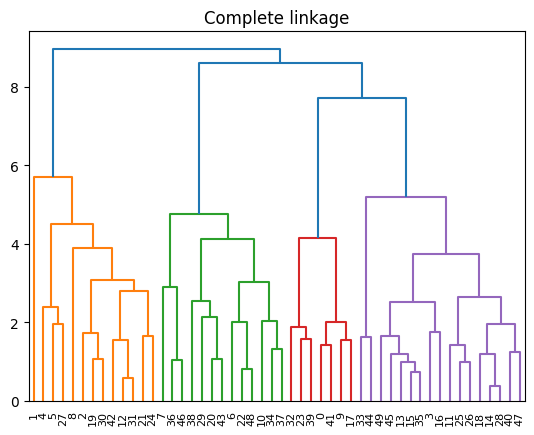

In [671]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete', metric='cityblock'), labels=pca_df.index)
plt.show()

This dendrogram uses complete linkage and "cityblock" distance, visually suggesting around 5 optimal clusters. We applied k=4 clusters to the K-means clustering visual

### K-means clustering

Text(0, 0.5, 'Dim 1')

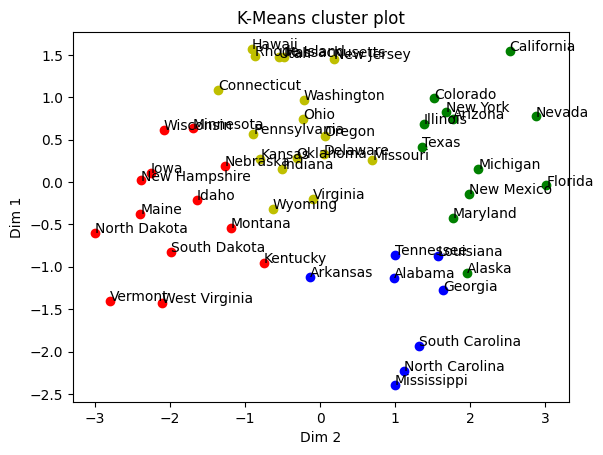

In [672]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = cities[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")

This plot shows the states grouped into distinct clusters based on their principal components, revealing common patterns related to crime rates and urbanization.
The red cluster are the states that typically low in crime rate which have lower urban populations.
The yellow cluster show the states with moderate crime rates with mostly moderate urban populations.
The green cluster show the states with high crime rates with the most populated people.
The blue cluster are the states that also show high crime rates, but tend to have lower populations than the green cluster.
From this plot we can see that the clusters are mainly categorised by the cities's crime rate and somewhat categorised by urban population.